# ***Examen práctico parical 4***
### Luis Eduardo Jiménez del Muro - 12/05/2025
---

# **Paqueterías**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier, log_evaluation, early_stopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import shap

import time

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

## *Funciones para gráficas*

In [41]:
"""
Gráfica de las varianza explicada por cada componente
--------------------------------------------------------------------------------------------------------
"""
def plot_varianza_explicada(varianza_explicada):
    plt.figure()
    plt.barh(varianza_explicada.index, varianza_explicada[0], color='cadetblue', zorder=2, height=0.5)

    for i, v in enumerate(varianza_explicada[0]):
        plt.text(v + 0.001, i, f'{v:.2f}')

    plt.title('Varianza explicada por cada componente principal', fontsize=16, fontweight='bold')
    plt.xlabel('Varianza explicada')
    plt.ylabel('Componente principal')
    plt.grid(alpha=0.4, linestyle='--', axis='x', zorder=0)
    plt.show()


"""
Graficar el método del Codo
--------------------------------------------------------------------------------------------------------
"""
def elbow_method(data, max_clusers=11):
    inertias = []

    K_range = range(1, max_clusers)

    for i in K_range:
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=i, random_state=42))
        ])
        pipeline.fit(data)
        inertias.append(pipeline.named_steps['kmeans'].inertia_)

    plt.figure()
    plt.plot(K_range, inertias, marker='o', linestyle='--', color='cadetblue')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inercia')
    plt.title('Método del Codo')
    plt.grid(alpha=0.5, ls='--')
    plt.xticks(K_range)
    plt.show()


"""
Scatter plot de los componentes principales con KMeans
--------------------------------------------------------------------------------------------------------
"""
def plot_xcomponents_clusters(X_componentes, PCA1, PCA2):
    plt.figure()
    scatter = plt.scatter(X_componentes[PCA1], X_componentes[PCA2], s=20, c=X_componentes['cluster'], cmap='viridis', zorder=2)
    plt.title('Scatter plot de los componentes principales con KMeans')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter, label='Cluster', ticks=[1, 2, 3])
    plt.grid(alpha=0.4, linestyle='--', zorder=0)
    plt.show()


"""
Clusterización
--------------------------------------------------------------------------------------------------------
"""
def cluster(X, n_clusters):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42))
    ])
    pipeline.fit(X)
    return pipeline.named_steps['kmeans'].labels_ + 1


"""
Grafica de calibración
--------------------------------------------------------------------------------------------------------
"""
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$')
    plt.grid(alpha=0.3, ls='--')
    plt.legend(fontsize=12, loc='best')
    plt.show()


"""
Roc Curve
--------------------------------------------------------------------------------------------------------
"""
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)

    plt.title('ROC Curve')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Histograma de probabilidades
--------------------------------------------------------------------------------------------------------
"""
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})

    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], stat='density', 
                 color='seagreen', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], stat='density', 
                 color='cadetblue', alpha=0.65, kde=True, bins=20, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.4f}', color='black', fontsize=10)
    plt.title(f'{type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.show()


"""
Ajuste de LightGBM
--------------------------------------------------------------------------------------------------------
"""
def lgbm(X_train, y_train, X_test, y_test):

    model = LGBMClassifier(
        n_estimators=100_000,
        max_depth=6,
        learning_rate=0.1,
        lambda_l2=0.1,
        metric='auc',
        feature_fraction=0.8,
        subsample=0.5,
        num_leaves=10,
        n_jobs=-1,
        random_state=42,
        verbosity=-1
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
                callbacks=[early_stopping(50), log_evaluation(100)], eval_metric='auc')

    predicciones = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    gain = model.booster_.feature_importance(importance_type='gain')

    return model, predicciones, auc, gain

# **1. PCA**

## *Preparar los datos*

In [42]:
data = pd.read_csv('data/hr_role.csv')
data['Attrition'] = data['Attrition'].map({'Yes': True, 'No': False})
data = pd.get_dummies(data)
data = data.drop(columns=['OverTime_No', 'Gender_Female'])

target = 'Attrition'
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

## *Escalar los datos y obtener el objeto PCA*

In [43]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])
pipeline.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

## *Varianzas explicada por componente*

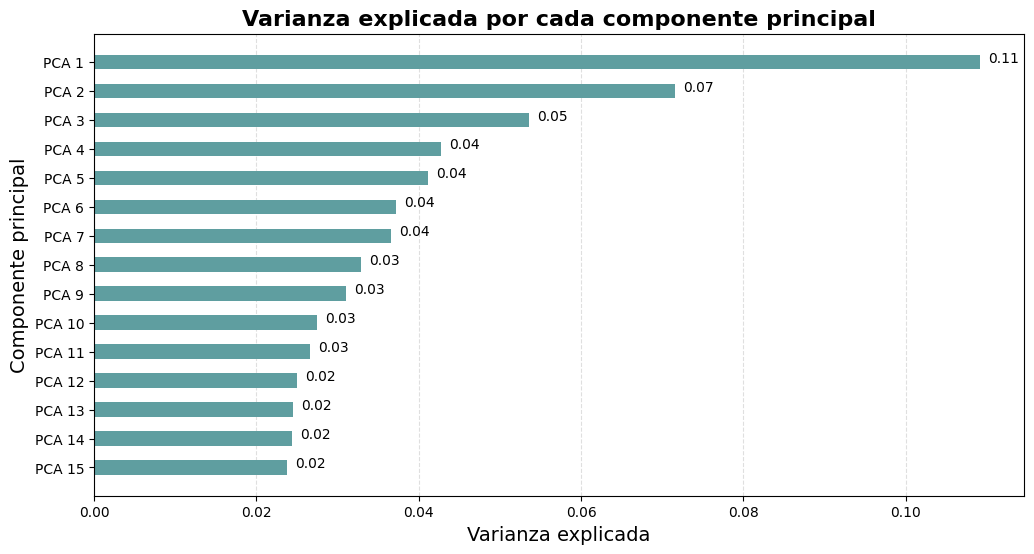

In [44]:
objeto_pca = pipeline.named_steps['pca']
X_pca = pipeline.transform(X)

X_componentes = pd.DataFrame(X_pca, columns=[f'PCA {i+1}' for i in range(X.shape[1])])
varianza_explicada = pd.DataFrame([explicacion for explicacion in objeto_pca.explained_variance_ratio_]).T
varianza_explicada.columns = [f'PCA {i+1}' for i in range(X.shape[1])]
varianza_explicada = varianza_explicada.T.head(15).sort_values(by=0, ascending=True)

plot_varianza_explicada(varianza_explicada)

# **2. K-Means**

## *Método del codo*

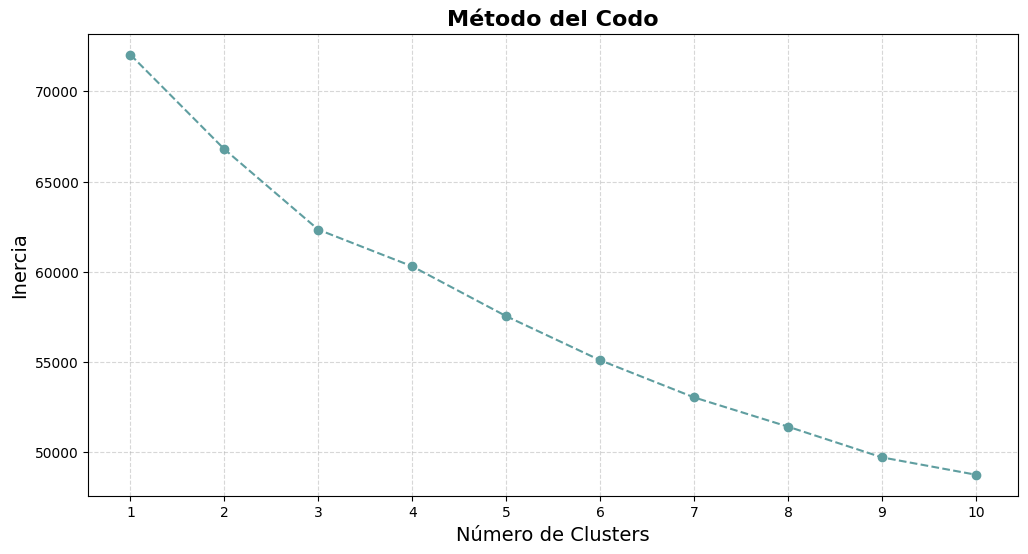

In [45]:
# Prueba del codo
elbow_method(X)

## *Clusterización*

In [46]:
clusters = cluster(X, 3)
X['Cluster'] = clusters
X.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,MonthlyIncome,MonthlyRate,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_Yes,Cluster
0,41,1102,1,2,2,94,3,2,5993,19479,...,False,False,True,False,False,False,True,True,True,2
1,49,279,8,1,3,61,2,2,5130,24907,...,False,True,False,False,False,True,False,True,False,1
2,37,1373,2,2,4,92,2,1,2090,2396,...,False,False,False,False,False,False,True,True,True,1
3,33,1392,3,4,4,56,3,1,2909,23159,...,False,True,False,False,False,True,False,True,True,1
4,27,591,2,1,1,40,3,1,3468,16632,...,False,False,False,False,False,True,False,True,False,1


## *Gráfica de las primeras dos componentes con clústeres*

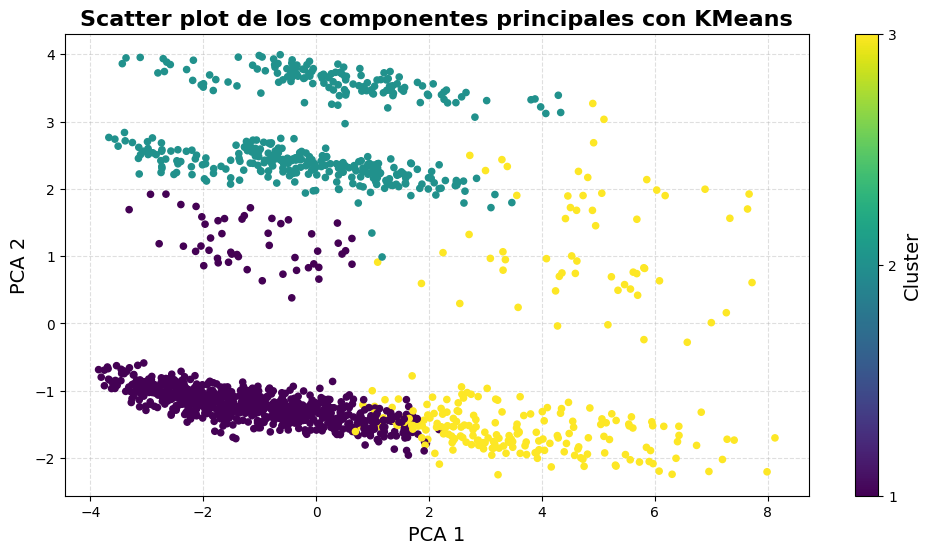

In [47]:
X_componentes['cluster'] = clusters
plot_xcomponents_clusters(X_componentes, 'PCA 1', 'PCA 2')

# **3. Hacer Modelos**

## *a) lightgbm con las variables y explicar los shaps*

In [48]:
X = X.drop(columns=['Cluster'])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.996137	valid_1's auc: 0.777778
Early stopping, best iteration is:
[149]	training's auc: 0.999561	valid_1's auc: 0.79085


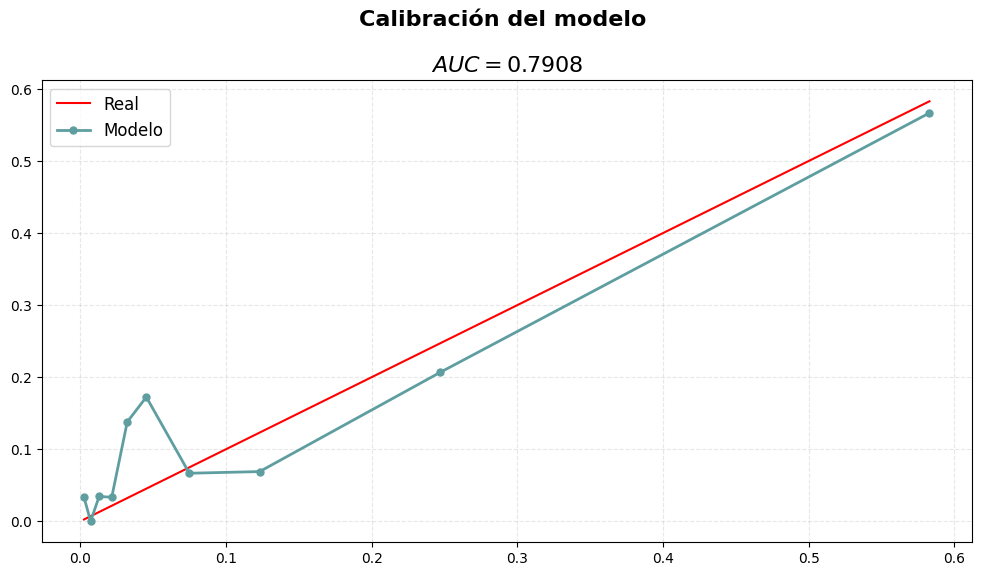

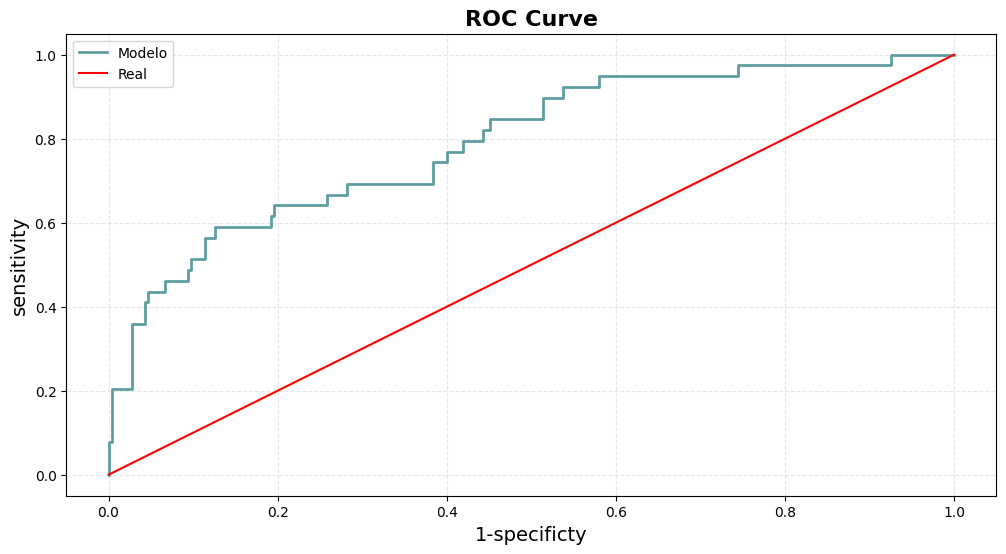

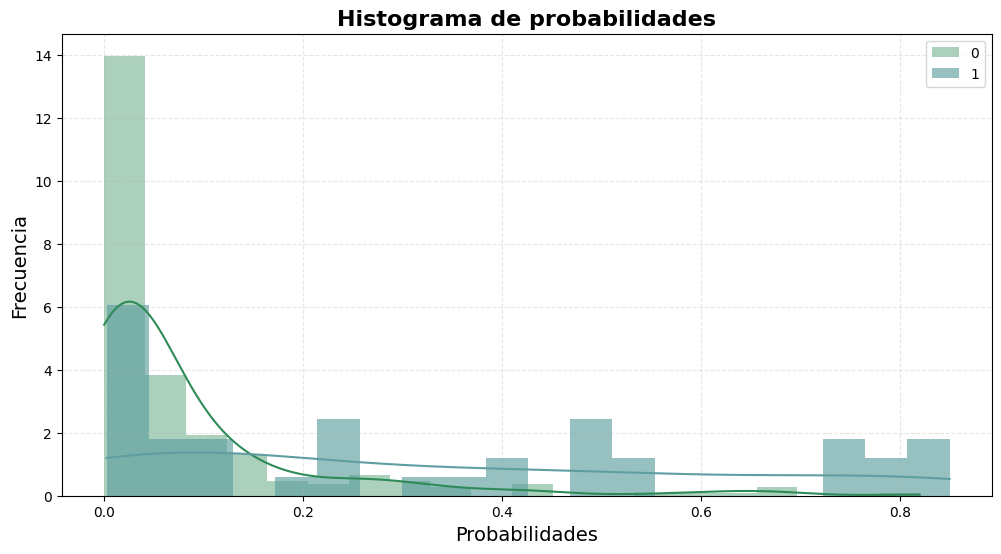

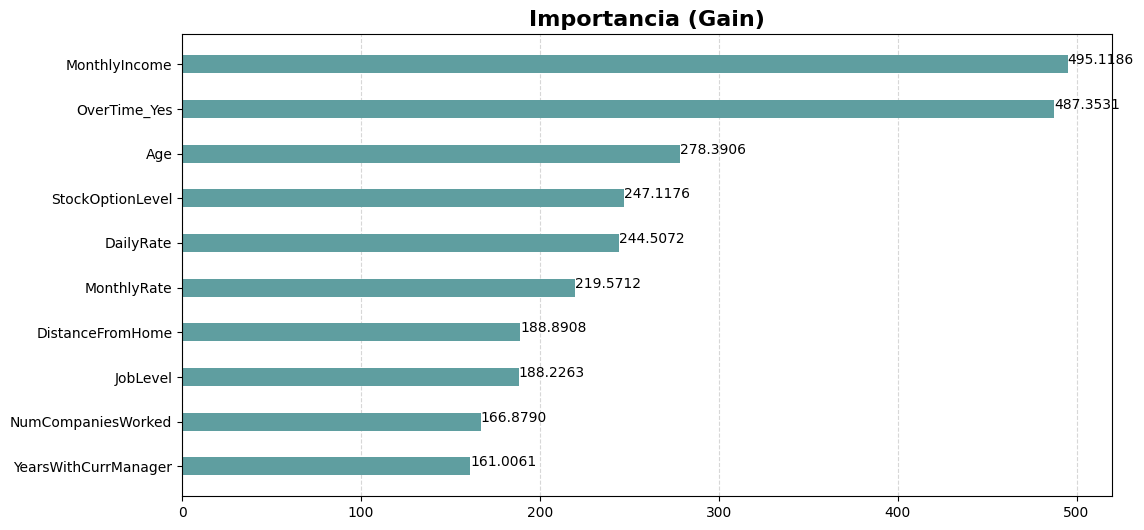

In [50]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

calibracion(predicciones, y_test, 10)
roc_curve_graph(predicciones, y_test)
histograma(predicciones, y_test)
importance_plot(X.columns, gain, 'Importancia (Gain)', 10)

### Shap values para una predicción en el conjunto de prueba

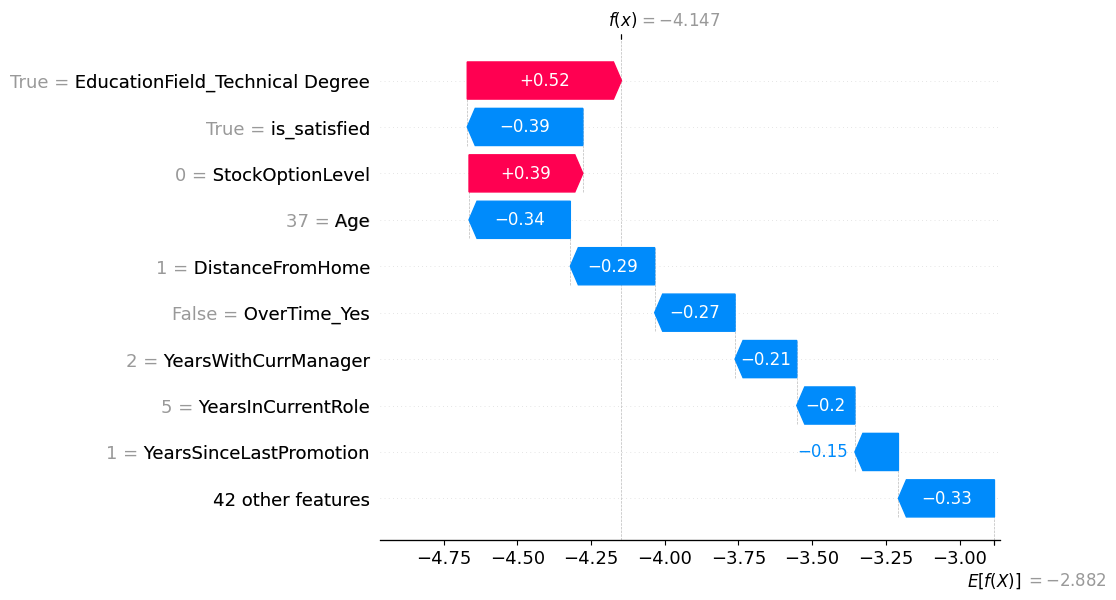

In [51]:
X_shap = X_test.copy()
X_shap = X_test.sample(int(len(X_test)*0.7), random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))

### Shap values generales

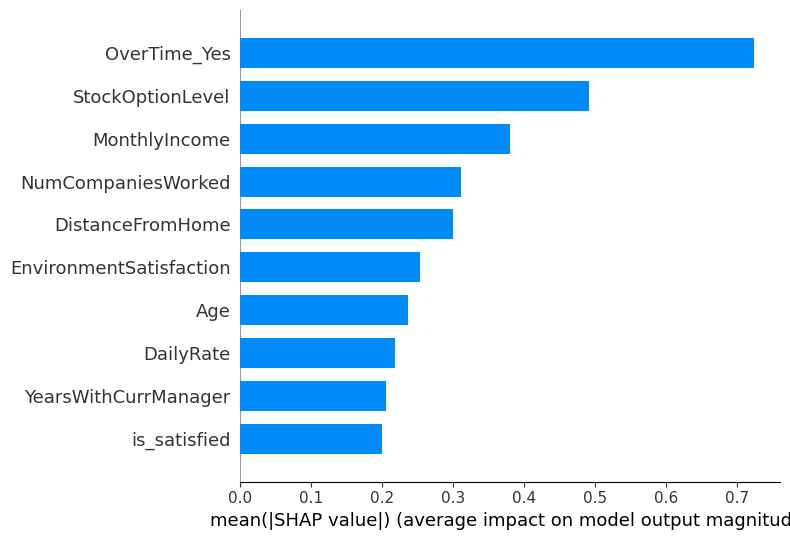

In [52]:
shap.summary_plot(shap_values, X_shap, plot_type="bar",  max_display=10)

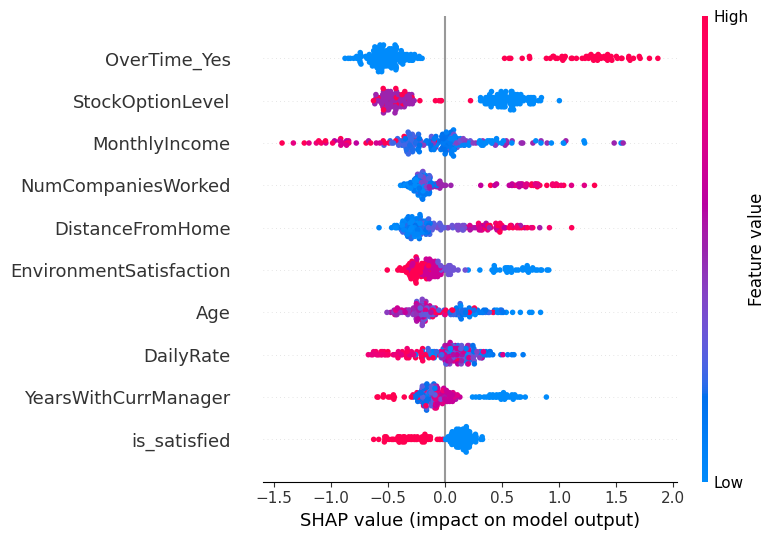

In [53]:
shap.summary_plot(shap_values, X_shap, plot_type='dot', max_display=10)

## *b) lightgbm con las componentes principales, cuantas son buenas?*

In [54]:
X_componentes = X_componentes.drop('cluster', axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_componentes, y, test_size=0.2, random_state=42)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	training's auc: 0.990297	valid_1's auc: 0.82363


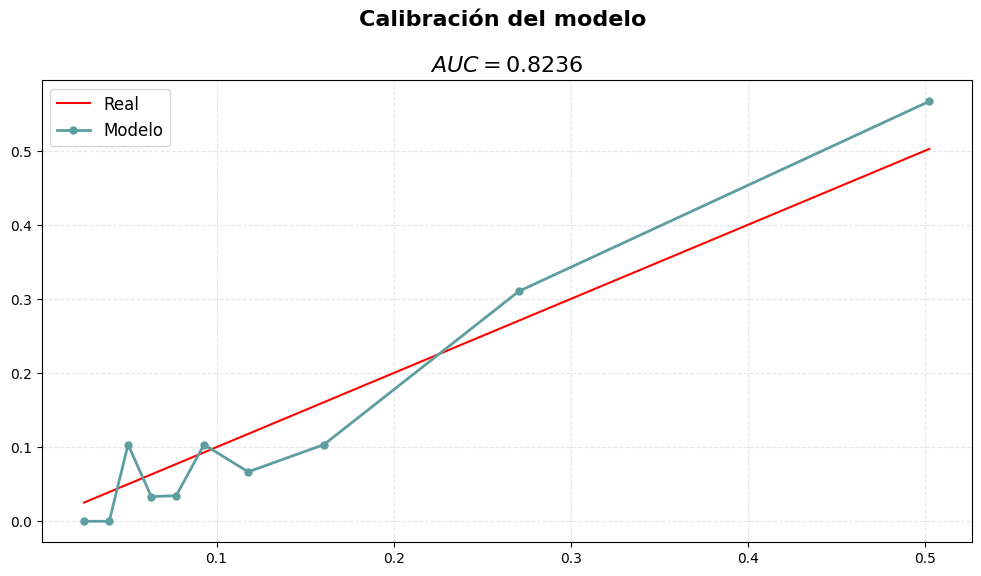

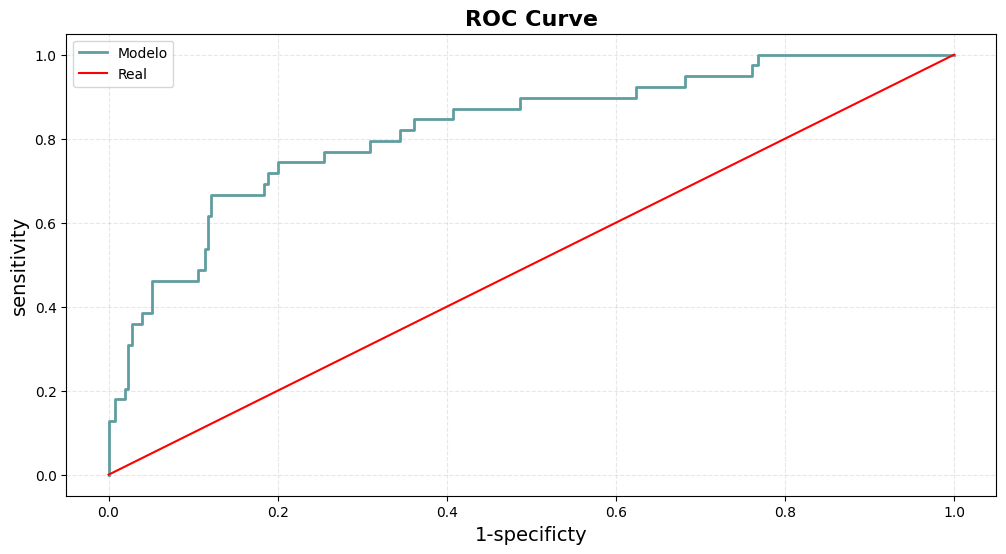

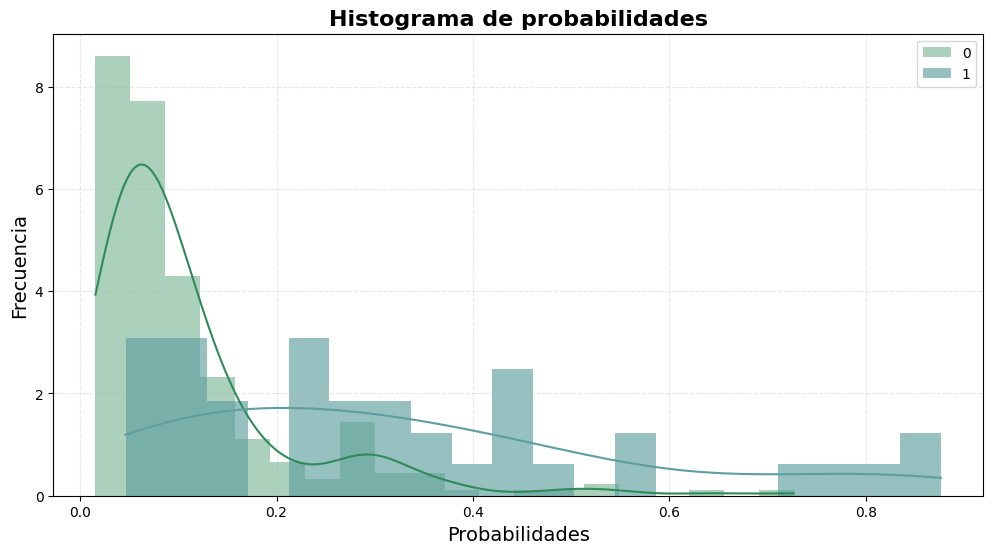

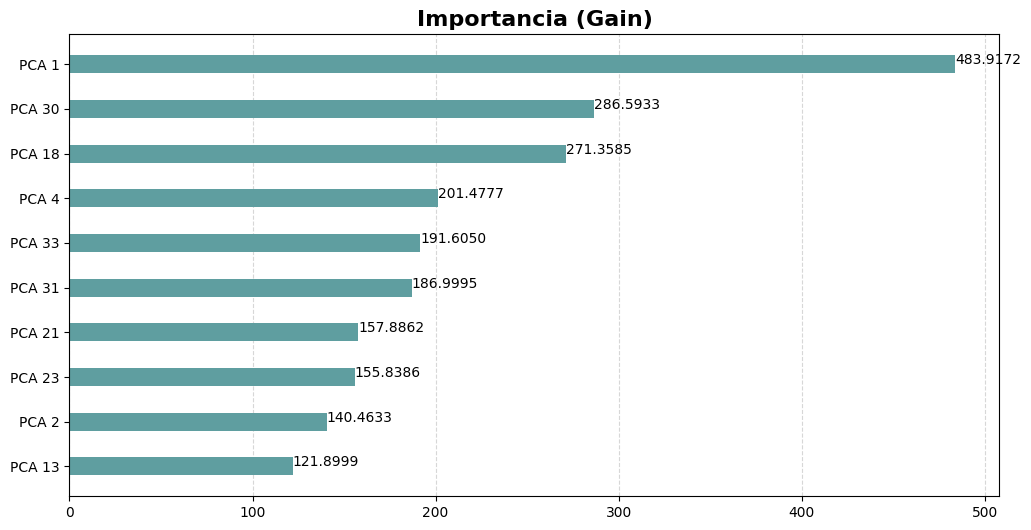

In [56]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

calibracion(predicciones, y_test, 10)
roc_curve_graph(predicciones, y_test)
histograma(predicciones, y_test)
importance_plot(X_train.columns, gain, 'Importancia (Gain)', 10)

### Shap values para una predicción en el conjunto de prueba

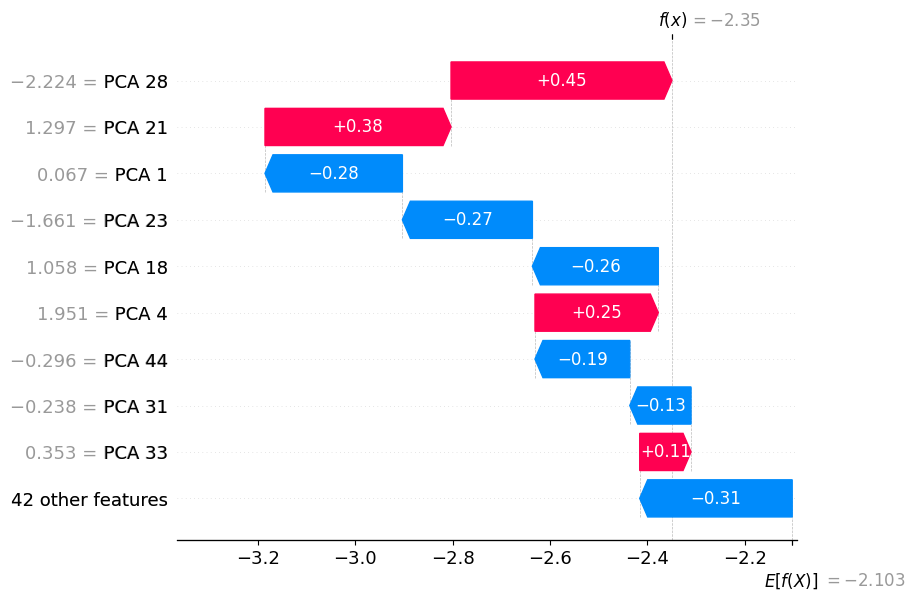

In [57]:
X_shap = X_test.copy()
X_shap = X_test.sample(int(len(X_test)*0.7), random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))

### Shap values generales

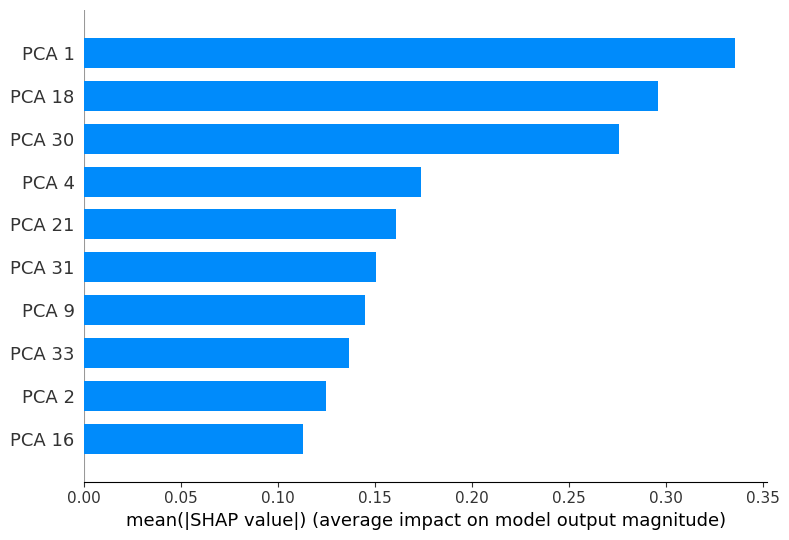

In [58]:
shap.summary_plot(shap_values, X_shap, plot_type="bar",  max_display=10)

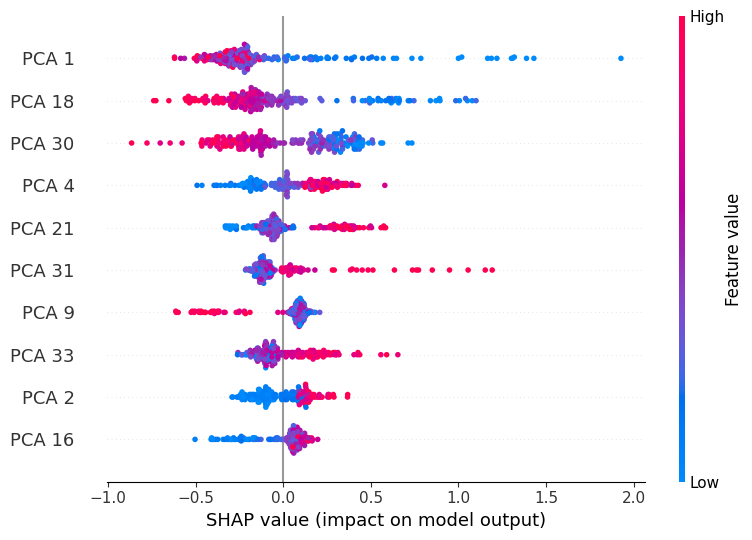

In [59]:
shap.summary_plot(shap_values, X_shap, plot_type='dot', max_display=10)

## *c) lightgbm con las componentes más importantes*

In [60]:
X_3_componentes = X_componentes[['PCA 1', 'PCA 18', 'PCA 30', 'PCA 4']]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_3_componentes, y, test_size=0.2, random_state=42)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	training's auc: 0.928632	valid_1's auc: 0.759175


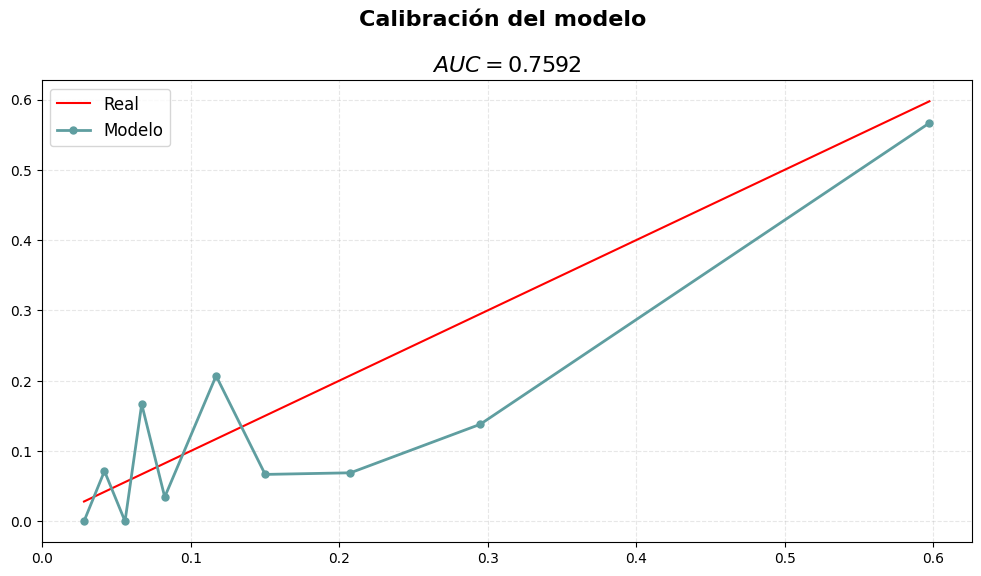

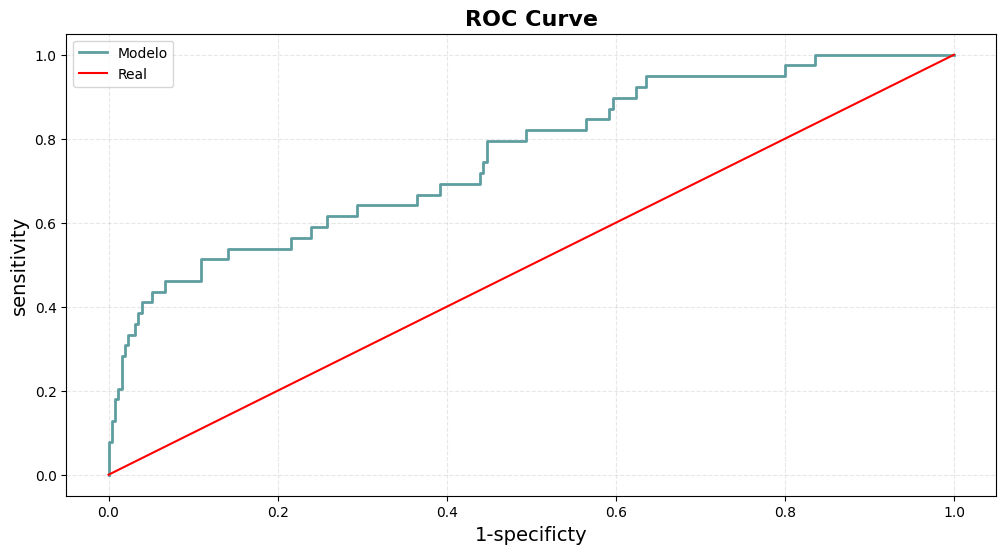

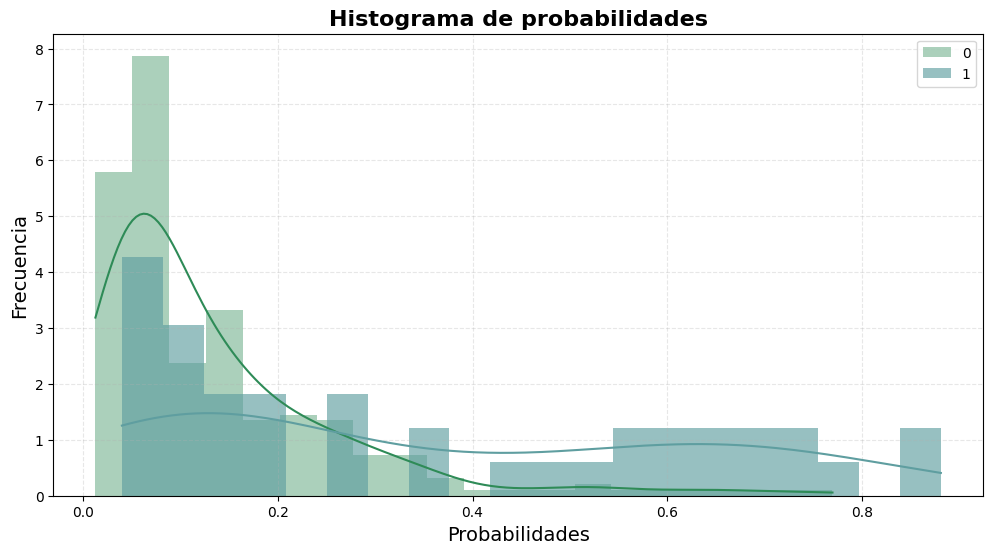

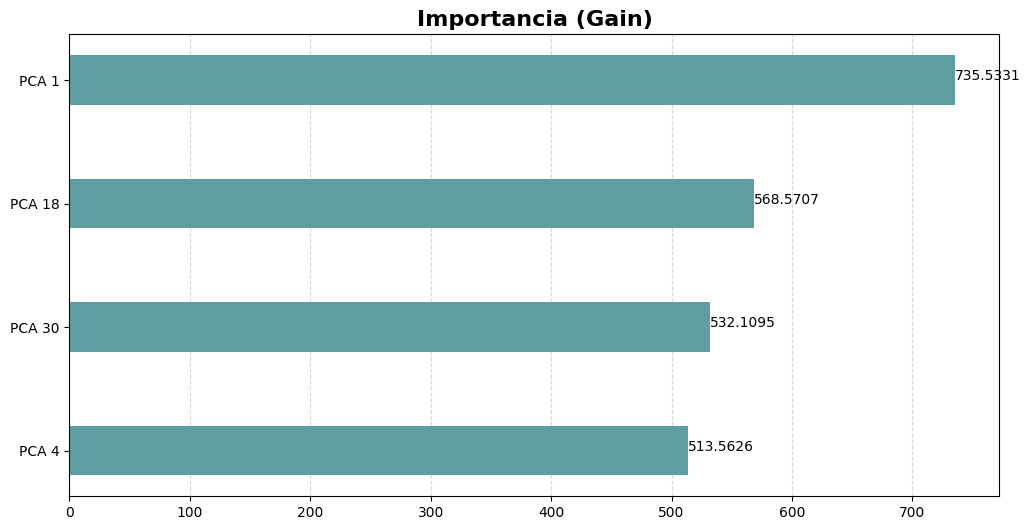

In [62]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

calibracion(predicciones, y_test, 10)
roc_curve_graph(predicciones, y_test)
histograma(predicciones, y_test)
importance_plot(X_3_componentes.columns, gain, 'Importancia (Gain)', 10)

### Shap values para una predicción en el conjunto de prueba

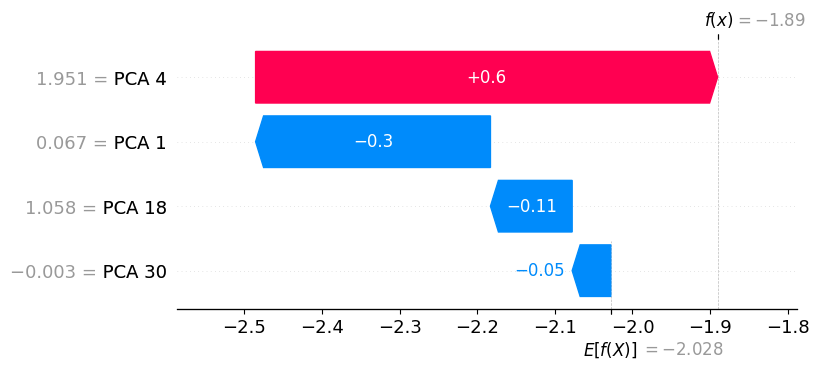

In [63]:
X_shap = X_test.copy()
X_shap = X_test.sample(int(len(X_test)*0.7), random_state=42)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

shap.initjs()
plt.figure()
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0], 
    base_values=explainer.expected_value, 
    data=X_shap.iloc[0], 
    feature_names=X_shap.keys()
))

### Shap values generales

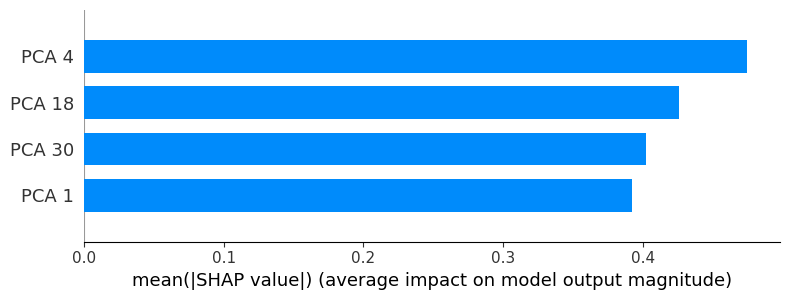

In [64]:
shap.summary_plot(shap_values, X_shap, plot_type="bar",  max_display=10)

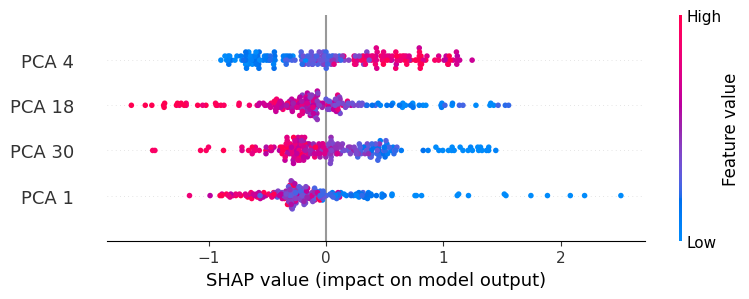

In [65]:
shap.summary_plot(shap_values, X_shap, plot_type='dot', max_display=10)

# **4. Dataset de Diabetes**

## *S-Learner*

In [66]:
data = pd.read_csv('data/diabetes.csv')
data = pd.get_dummies(data, columns=['gender'])
data['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [67]:
map_conditions = {
    'never':False, 'No Info':False, 
    'current':True, 'former':True, 'ever':True, 'not current':True
}

data['smoking_history'] = data['smoking_history'].map(map_conditions)
data.head()

,age,hypertension,heart_disease,smoking_history,bmi,diabetes,gender_Female,gender_Male,gender_Other
0,80.0,0,1,False,25.19,0,True,False,False
1,54.0,0,0,False,27.32,0,True,False,False
2,28.0,0,0,False,27.32,0,False,True,False
3,36.0,0,0,True,23.45,0,True,False,False
4,76.0,1,1,True,20.14,0,False,True,False


In [68]:
target = 'diabetes'
X = data.copy()
X = data.drop(target, axis=1)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
model, predicciones, auc, gain = lgbm(X_train, y_train, X_test, y_test)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.839711	valid_1's auc: 0.835882
Early stopping, best iteration is:
[102]	training's auc: 0.839831	valid_1's auc: 0.835904


In [70]:
X_test_counter0 = X_test.copy()
X_test_counter0['smoking_history'] = 0

X_test_counter1 = X_test.copy()
X_test_counter1['smoking_history'] = 1

In [71]:
df_cate = pd.DataFrame({
    'treatment0': model.predict_proba(X_test_counter0)[:,1],
    'treatment1': model.predict_proba(X_test_counter1)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bins_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test

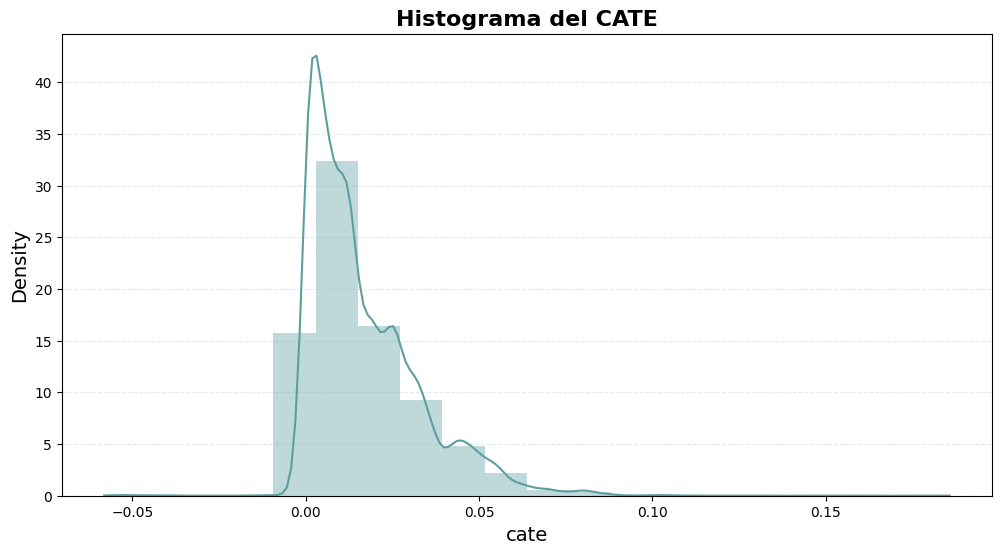

In [72]:
sns.histplot(df_cate['cate'], stat='density', 
                 color='cadetblue', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
plt.grid(alpha=0.3, ls='--', axis='y', zorder=0)
plt.title('Histograma del CATE')
plt.show()

In [73]:
df_cate.groupby('bins_cate').mean()

,treatment0,treatment1,cate,diabetes
bins_cate,,,,
1,0.010222,0.011128,0.000907,0.074442
2,0.015499,0.021331,0.005832,0.084263
3,0.041722,0.053738,0.012016,0.080153
4,0.111606,0.133604,0.021997,0.117424
5,0.204822,0.247340,0.042519,0.087062


## *T-Learner*

In [74]:
# Train: Smoke = 1
X_train_smoke1 = X_train[X_train['smoking_history'] == 1]
y_train_smoke1 = y_train.loc[X_train_smoke1.index]

# Train: Smoke = 0
X_train_smoke0 = X_train[X_train['smoking_history'] == 0]
y_train_smoke0 = y_train.loc[X_train_smoke0.index]

# Test: Smoke = 1
X_test_smoke1 = X_test[X_test['smoking_history'] == 1]
y_test_smoke1 = y_test.loc[X_test_smoke1.index]

# Test: Smoke = 0
X_test_smoke0 = X_test[X_test['smoking_history'] == 0]
y_test_smoke0 = y_test.loc[X_test_smoke0.index]

In [75]:
model_t0, predicciones, auc, gain = lgbm(X_train_smoke0, y_train_smoke0,
                                         X_test_smoke0, y_test_smoke0)

model_t1, predicciones, auc, gain = lgbm(X_train_smoke1, y_train_smoke1,
                                         X_test_smoke1, y_test_smoke1)

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.854305	valid_1's auc: 0.8479
Early stopping, best iteration is:
[93]	training's auc: 0.853852	valid_1's auc: 0.848019
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.806482	valid_1's auc: 0.793618
Early stopping, best iteration is:
[106]	training's auc: 0.80722	valid_1's auc: 0.793827


In [76]:
todos = X_test.copy()
todos = todos[X_train_smoke0.keys()]

df_cate = pd.DataFrame({
    'treatment0': model_t0.predict_proba(todos)[:,1],
    'treatment1': model_t1.predict_proba(todos)[:,1]
})
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']
df_cate['bins_cate'] = pd.qcut(df_cate['cate'], q=5, labels=False) + 1
df_cate['diabetes'] = y_test

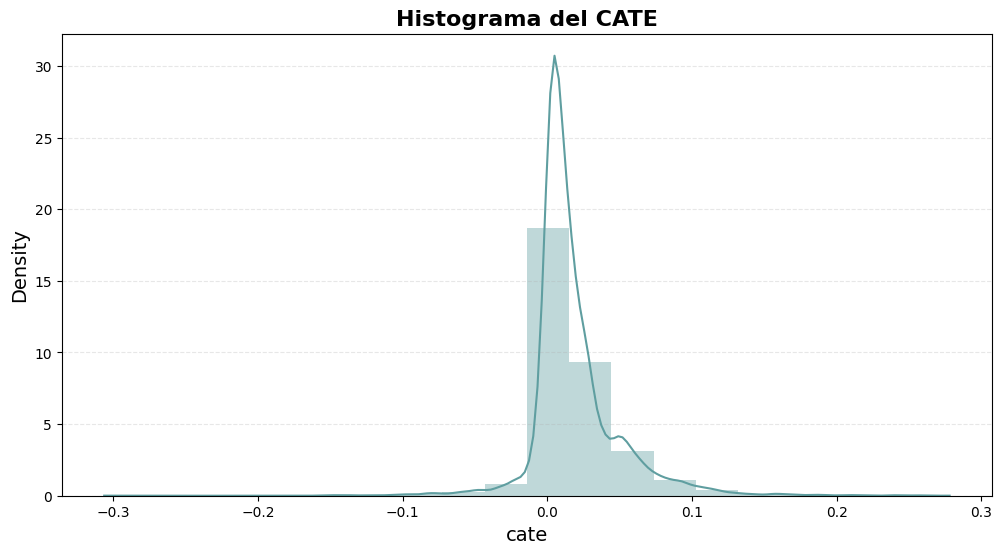

In [77]:
sns.histplot(df_cate['cate'], stat='density', 
                 color='cadetblue', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
plt.grid(alpha=0.3, ls='--', axis='y', zorder=0)
plt.title('Histograma del CATE')
plt.show()

In [78]:
df_cate.groupby('bins_cate').mean()

,treatment0,treatment1,cate,diabetes
bins_cate,,,,
1,0.080908,0.070823,-0.010085,0.084541
2,0.023988,0.028543,0.004555,0.073082
3,0.037080,0.048329,0.011249,0.101299
4,0.072303,0.095046,0.022743,0.096933
5,0.166799,0.230372,0.063573,0.088010
